<a href="https://colab.research.google.com/github/bhanuteja2001/COVID-19-XrayDetection/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid_image_data/filetrain (1).csv')
df.head()

,Unnamed: 0,filename,file,label
0,0,Image_ex_1.jpg,/content/drive/MyDrive/covid_image_data/train/...,0
1,1,Image_ex_2.jpg,/content/drive/MyDrive/covid_image_data/train/...,0
2,2,Image_ex_3.jpg,/content/drive/MyDrive/covid_image_data/train/...,0
3,3,Image_ex_4.jpg,/content/drive/MyDrive/covid_image_data/train/...,0
4,4,Image_ex_5.jpg,/content/drive/MyDrive/covid_image_data/train/...,0


In [ ]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,filename,file,label
0,Image_ex_1.jpg,/content/drive/MyDrive/covid_image_data/train/...,0
1,Image_ex_2.jpg,/content/drive/MyDrive/covid_image_data/train/...,0
2,Image_ex_3.jpg,/content/drive/MyDrive/covid_image_data/train/...,0
3,Image_ex_4.jpg,/content/drive/MyDrive/covid_image_data/train/...,0
4,Image_ex_5.jpg,/content/drive/MyDrive/covid_image_data/train/...,0


In [ ]:
df.shape

(2917, 2)

In [ ]:
df.label.value_counts()

0    1779
1    1138
Name: label, dtype: int64

In [ ]:
df = df.sample(frac = 1).reset_index(drop=True)

In [ ]:
Train = df

In [6]:
train_path

'/content/drive/MyDrive/covid_image_data/Train'

In [8]:
!pip install split-folders

In [13]:
import splitfolders
splitfolders.ratio(train_path, output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 2919 files [23:58,  2.03 files/s]


In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [37]:
IMAGE_SIZE = [224, 224]

train_path = '/content/output/train'
valid_path = '/content/output/val'


vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/output/train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoints_every_epoch = '/content/drive/MyDrive/covid_image_data/checkpoints_every_epoch/checkpoint_{epoch:03d}'
    checkpoint1 = ModelCheckpoint(filepath=checkpoints_every_epoch,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=1)
    checkpoint2 = EarlyStopping(monitor='val_accuracy', patience=3)
    
    return checkpoint1, checkpoint2

checkpoint_every_epoch = list(get_checkpoint_every_epoch())

In [38]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/output/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''


es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)





# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=checkpoint_every_epoch
)




Found 2334 images belonging to 2 classes.
Found 291 images belonging to 2 classes.
Epoch 1/50
73/73 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8295
Epoch 00001: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch/checkpoint_001
73/73 [==============================] - 47s 640ms/step - loss: 0.3985 - accuracy: 0.8295 - val_loss: 0.2447 - val_accuracy: 0.8797
Epoch 2/50
73/73 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.9087
Epoch 00002: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch/checkpoint_002
73/73 [==============================] - 46s 635ms/step - loss: 0.2358 - accuracy: 0.9087 - val_loss: 0.1553 - val_accuracy: 0.9450
Epoch 3/50
73/73 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9426
Epoch 00003: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch/checkpoint_003
73/73 [==============================] - 46s 63

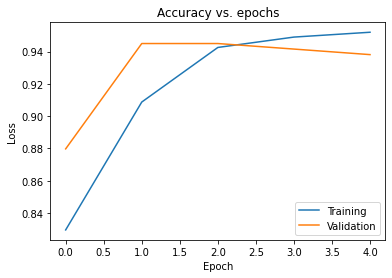

In [39]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

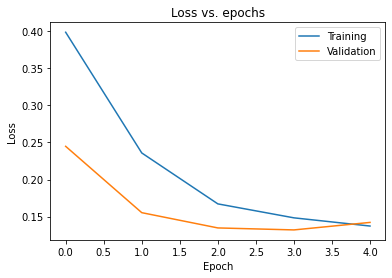

In [40]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## Testing

In [41]:
df_testing = pd.read_csv('/content/drive/MyDrive/covid_image_data/Testing_set_covid.csv')
df_testing.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [42]:
images_testing = [[fname, '/content/drive/MyDrive/covid_image_data/test/' + fname[:-4] + '.jpg'] for fname in df_testing['filename']]
images_testing = pd.DataFrame(images_testing)
images_testing.columns = ['filename', 'file']
images_testing

,filename,file
0,Image_1.jpg,/content/drive/MyDrive/covid_image_data/test/I...
1,Image_2.jpg,/content/drive/MyDrive/covid_image_data/test/I...
2,Image_3.jpg,/content/drive/MyDrive/covid_image_data/test/I...
3,Image_4.jpg,/content/drive/MyDrive/covid_image_data/test/I...
4,Image_5.jpg,/content/drive/MyDrive/covid_image_data/test/I...
...,...,...
865,Image_866.jpg,/content/drive/MyDrive/covid_image_data/test/I...
866,Image_867.jpg,/content/drive/MyDrive/covid_image_data/test/I...
867,Image_868.jpg,/content/drive/MyDrive/covid_image_data/test/I...
868,Image_869.jpg,/content/drive/MyDrive/covid_image_data/test/I...


In [43]:
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
test_image = []
for i in tqdm(range(images_testing.shape[0])):
    img = load_img(images_testing['file'][i], target_size=(224, 224, 3), grayscale=False)
    img = img_to_array(img)
    img = img/255
    test_image.append(img)
X = np.array(test_image)

100%|██████████| 870/870 [07:16<00:00,  1.99it/s]


In [44]:
prediction = model.predict(X)

In [46]:
K = pd.DataFrame(prediction)

In [47]:
K.head()

,0,1
0,0.998255,0.001745
1,0.999949,0.000051
2,0.004157,0.995843
3,0.999816,0.000184
4,0.134885,0.865115


In [48]:
L = []
for i in range(len(K[0])):
  if K[0][i] > 0.5:
    L.append(0)
  else:
    L.append(1) 

In [50]:
# To download the csv file locally
from google.colab import files
res = pd.DataFrame(L) 
res.columns = ["prediction"]
res.to_csv('prediction_results.csv')         
files.download('prediction_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>